# Basic Power Flow Analysis and OPF

See Section 10.1 of 000421

In [26]:
import numpy as np
import networkx as nx
import pandas as pd

## Network creation

In [4]:
# Create graph
G = nx.DiGraph()

# Nodes with max set point and complex demand
G.add_node(0,name='slack',smax=10,d=0)
G.add_node(1,name='step',smax=0,d=0)
G.add_node(2,name='house',smax=0,d=1.2+0.3j)
G.add_node(3,name='solar',smax=1,d=0)
G.add_node(4,name='building',smax=0,d=2.5+0.9j)
G.add_node(5,name='wind',smax=1.5,d=0)

# Edges with admittance
G.add_edge(0,1,y=1/(0.0075+0.010j),thlim=2)
G.add_edge(1,2,y=1/(0.0080+0.011j),thlim=2)
G.add_edge(2,3,y=1/(0.0090+0.018j),thlim=2)
G.add_edge(1,4,y=1/(0.0040+0.004j),thlim=2)
G.add_edge(4,5,y=1/(0.0050+0.006j),thlim=2)

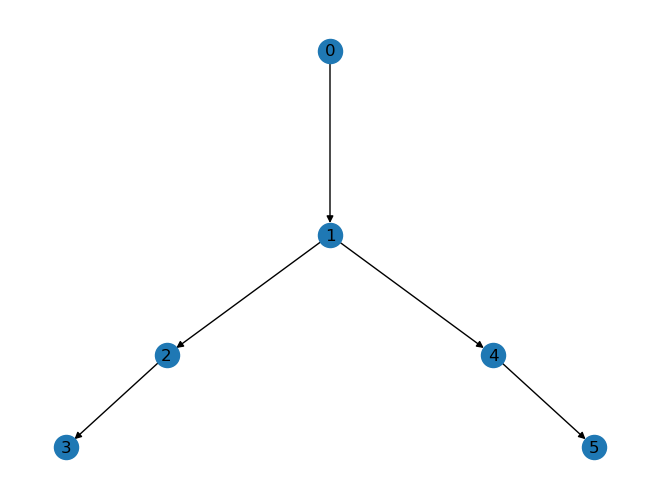

In [3]:
nx.draw(G,with_labels=True,pos=nx.spectral_layout(G))

## Admittance matrix

In [6]:
A = nx.incidence_matrix(G, oriented=True)
Yp = np.diag([G.edges[k]["y"] for k in G.edges])
Ybus = A @ Yp @ A.T

In [20]:
# Admittances on edges?
print(Yp)
print(Yp.shape)

[[ 48.         -64.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j        ]
 [  0.          +0.j          43.24324324 -59.45945946j
    0.          +0.j           0.          +0.j
    0.          +0.j        ]
 [  0.          +0.j           0.          +0.j
  125.        -125.j           0.          +0.j
    0.          +0.j        ]
 [  0.          +0.j           0.          +0.j
    0.          +0.j          22.22222222 -44.44444444j
    0.          +0.j        ]
 [  0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
   81.96721311 -98.36065574j]]
(5, 5)


In [21]:
print(A)
print(A.shape)

  (0, 0)	-1.0
  (1, 0)	1.0
  (1, 1)	-1.0
  (2, 1)	1.0
  (1, 2)	-1.0
  (4, 2)	1.0
  (2, 3)	-1.0
  (3, 3)	1.0
  (4, 4)	-1.0
  (5, 4)	1.0
(6, 5)


In [15]:
print(Ybus)

[[  48.         -64.j          -48.         +64.j
     0.          +0.j            0.          +0.j
     0.          +0.j            0.          +0.j        ]
 [ -48.         +64.j          216.24324324-248.45945946j
   -43.24324324 +59.45945946j    0.          +0.j
  -125.        +125.j            0.          +0.j        ]
 [   0.          +0.j          -43.24324324 +59.45945946j
    65.46546547-103.9039039j   -22.22222222 +44.44444444j
     0.          +0.j            0.          +0.j        ]
 [   0.          +0.j            0.          +0.j
   -22.22222222 +44.44444444j   22.22222222 -44.44444444j
     0.          +0.j            0.          +0.j        ]
 [   0.          +0.j         -125.        +125.j
     0.          +0.j            0.          +0.j
   206.96721311-223.36065574j  -81.96721311 +98.36065574j]
 [   0.          +0.j            0.          +0.j
     0.          +0.j            0.          +0.j
   -81.96721311 +98.36065574j   81.96721311 -98.36065574j]]


In [16]:
# positive semidefinite if has non-negative eigenvalues?
# Confirm this
print(np.linalg.eigvals(Ybus.real))

[ 3.55850779e+02  1.53742122e+02  6.95171530e+01  4.52945499e+01
 -4.32319948e-15  1.64607529e+01]


## Block matrices

In [17]:
n = G.number_of_nodes()
YN0 = Ybus[1:n,0]
YNN = Ybus[1:n,1:n]
ZNN = np.linalg.inv(YNN)
d = np.array([G.nodes[k]['d'] for k in G.nodes])
print(YN0)
print(YNN)

[-48.+64.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j]
[[ 216.24324324-248.45945946j  -43.24324324 +59.45945946j
     0.          +0.j         -125.        +125.j
     0.          +0.j        ]
 [ -43.24324324 +59.45945946j   65.46546547-103.9039039j
   -22.22222222 +44.44444444j    0.          +0.j
     0.          +0.j        ]
 [   0.          +0.j          -22.22222222 +44.44444444j
    22.22222222 -44.44444444j    0.          +0.j
     0.          +0.j        ]
 [-125.        +125.j            0.          +0.j
     0.          +0.j          206.96721311-223.36065574j
   -81.96721311 +98.36065574j]
 [   0.          +0.j            0.          +0.j
     0.          +0.j          -81.96721311 +98.36065574j
    81.96721311 -98.36065574j]]


## Fixed point algorithm

In [23]:
def LoadFlow(sN,dN):
    v0 = 1+0j
    vN = np.ones(n-1)*v0
    for t in range(10):
        vN = ZNN@(np.conj((sN-dN)/vN)-v0*YN0)
        vT = np.hstack([v0,vN]);
        sT = vT*np.conj(Ybus@vT)
        err = np.linalg.norm(sT[1:n]-(sN-dN))
    print('Load Flow, after 10 iterations the error is',err)
    return vT

In [25]:
VT = LoadFlow(np.zeros(n-1),d[1:n])
ST = VT*np.conj(Ybus@VT)
pL = sum(ST)
print('Loss',pL)
for (k,m) in G.edges:
    Sf = Ybus[k,m]*(VT[k]-VT[m])
    print('flow',(k,m),np.abs(Sf))

Load Flow, after 10 iterations the error is 9.833373286846192e-12
Loss (0.1731831335272755+0.22089148762912691j)
flow (0, 1) 4.125588467764153
flow (1, 2) 1.3111259268831168
flow (1, 4) 2.8185600232227275
flow (2, 3) 1.111935011801867e-14
flow (4, 5) 3.3525890660699923e-14


In [31]:
sum(ST)

(0.1731831335272755+0.22089148762912691j)

In [27]:
results = pd.DataFrame()
results['name'] = [G.nodes[k]['name'] for k in G.nodes]
results['vpu'] = np.abs(VT)
results['ang'] = np.angle(VT)*180/np.pi
results['pnode'] = np.round(ST.real,4)
results['qnode'] = np.round(ST.imag,4)
results.head(n)

,name,vpu,ang,pnode,qnode
0,slack,1.000000,0.000000,3.8732,1.4209
1,step,0.957154,-1.680835,0.0000,0.0000
2,house,0.943412,-2.366124,-1.2000,-0.3000
3,solar,0.943412,-2.366124,0.0000,0.0000
4,building,0.942703,-2.087231,-2.5000,-0.9000
5,wind,0.942703,-2.087231,-0.0000,-0.0000
